In [690]:
import pandas as pd
import numpy as np
import calendar

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [598]:
data = pd.read_csv("/content/drive/MyDrive/UpGrad/train.csv")

In [599]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [600]:
data.shape

(1460, 81)

In [601]:
data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [602]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [603]:
# Checking the percentage of missing values
round(100*(data.isnull().sum()/len(data.index)), 2)

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
                 ...  
MoSold            0.00
YrSold            0.00
SaleType          0.00
SaleCondition     0.00
SalePrice         0.00
Length: 81, dtype: float64

In [604]:
nullablecols = data.columns[data.isna().any()].tolist()
nullablecols

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [605]:
nullablepercentages = round(100*(data[nullablecols].isnull().sum()/len(data[nullablecols].index)), 2)
nullablepercentages

LotFrontage     17.74
Alley           93.77
MasVnrType       0.55
MasVnrArea       0.55
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

In [606]:
# dropping columns with lot of missing values
colswithmissingvalues = ['Alley', 'FireplaceQu','PoolQC','Fence','MiscFeature']

In [607]:
# Drop instant and dteday columns since they are all unique values
data.drop(colswithmissingvalues, axis = 1, inplace=True)


In [608]:
#drop id since its all unique values
data.drop(['Id'], axis = 1, inplace=True)

In [609]:
#find columns which do not have enough distribution/variation of values
catcolumns = ['MSSubClass','MSZoning','Street','LotShape','LandContour','Utilities','LotConfig','LandSlope',
              'Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','RoofStyle','RoofMatl',
              'Exterior1st','Exterior2nd','MasVnrType','ExterQual','ExterCond','Foundation',
              'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF2','Heating',
              'HeatingQC','CentralAir','Electrical','KitchenQual','Functional','GarageType', 
              'GarageFinish','GarageQual','GarageCond','PavedDrive','SaleType','SaleCondition','YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']
valuecounts = data[catcolumns].apply(lambda x: x.value_counts(normalize=True)).T.stack()
nonvariantcols = valuecounts.loc[lambda x: x > .80]
nonvariantcols

Street         Pave       0.995890
LandContour    Lvl        0.897945
Utilities      AllPub     0.999315
LandSlope      Gtl        0.946575
Condition1     Norm       0.863014
Condition2     Norm       0.989726
BldgType       1Fam       0.835616
RoofMatl       CompShg    0.982192
ExterCond      TA         0.878082
BsmtCond       TA         0.921293
BsmtFinType2   Unf        0.883263
BsmtFinSF2     0          0.885616
Heating        GasA       0.978082
CentralAir     Y          0.934932
Electrical     SBrkr      0.914325
Functional     Typ        0.931507
GarageQual     TA         0.950689
GarageCond     TA         0.961566
PavedDrive     Y          0.917808
SaleType       WD         0.867808
SaleCondition  Normal     0.820548
dtype: float64

In [610]:
nonvariantcolstodelete = ['Street',
'LandContour',
'Utilities',
'LandSlope',
'Condition1',
'Condition2',
'BldgType',
'RoofMatl',
'ExterCond',
'BsmtCond',
'BsmtFinType2',
'BsmtFinSF2',
'Heating',
'CentralAir',
'Electrical',
'Functional',
'GarageQual',
'GarageCond',
'PavedDrive',
'SaleType',
'SaleCondition']

In [611]:
# dropping columns with lot of missing values
data.drop(nonvariantcolstodelete, axis = 1, inplace=True)

In [612]:
# drop neighborhood column
data.drop(['Neighborhood'],axis=1,inplace=True)

In [613]:
catcolumns = list(set(catcolumns)-set(nonvariantcolstodelete)-set(colswithmissingvalues))
catcolumns

['GarageFinish',
 'YearRemodAdd',
 'Foundation',
 'Exterior1st',
 'LotConfig',
 'KitchenQual',
 'MasVnrType',
 'LotShape',
 'GarageYrBlt',
 'OverallCond',
 'YrSold',
 'MSZoning',
 'BsmtExposure',
 'HeatingQC',
 'YearBuilt',
 'MSSubClass',
 'BsmtQual',
 'Exterior2nd',
 'OverallQual',
 'GarageType',
 'BsmtFinType1',
 'RoofStyle',
 'HouseStyle',
 'ExterQual']

### Replace NA,None with NA

In [614]:
def fixInvalidStringsWithNA(df,columns):
    for column in columns:
        df[column] = df[column].fillna('NA')
        df[column] = df[column].fillna('None')
    return df

dna = fixInvalidStringsWithNA(data, ['GarageFinish','MasVnrType'])

### Replace NA with Median


In [615]:
nan_values = data.isna()
nan_columns = nan_values.any()


columns_with_nan = data.columns[nan_columns].tolist()
#print(columns_with_nan)
numeric_nan_columns = set(columns_with_nan) -  set(catcolumns)
#print(numeric_nan_columns)
cat_nan_columns = set(columns_with_nan) - set(numeric_nan_columns)
numeric_columns = set(data.columns.tolist()) - set(catcolumns)

numeric_columns_list = list(numeric_columns)

#data[numeric_nan_columns] = data[numeric_nan_columns].apply(lambda x: x.fillna(x.median()))

In [616]:
numeric_nan_columns

{'LotFrontage', 'MasVnrArea'}

In [617]:
data['GarageFinish']

0       RFn
1       RFn
2       RFn
3       Unf
4       RFn
       ... 
1455    RFn
1456    Unf
1457    RFn
1458    Unf
1459    Fin
Name: GarageFinish, Length: 1460, dtype: object

In [618]:
def replaceNAWithMedian(df, columns):
  df = df.apply(lambda x: x.fillna(x.median()) if x.name in columns else x)
  return df

data = replaceNAWithMedian(data, numeric_nan_columns)

##Visualising Categorical Variables

In [619]:
def divide_chunks(l, n):
    for i in range(0, len(l), n): 
        yield l[i:i + n]

In [620]:
def drawBoxPlot(df, columns):
  collist = divide_chunks(columns, 16)
  for cols in collist:
    plt.figure(figsize=(30,20))
    for index, item in enumerate(cols, start=1):
      plt.subplot(4,4,index)
      sns.boxplot(x = item, y = 'SalePrice', data = df)

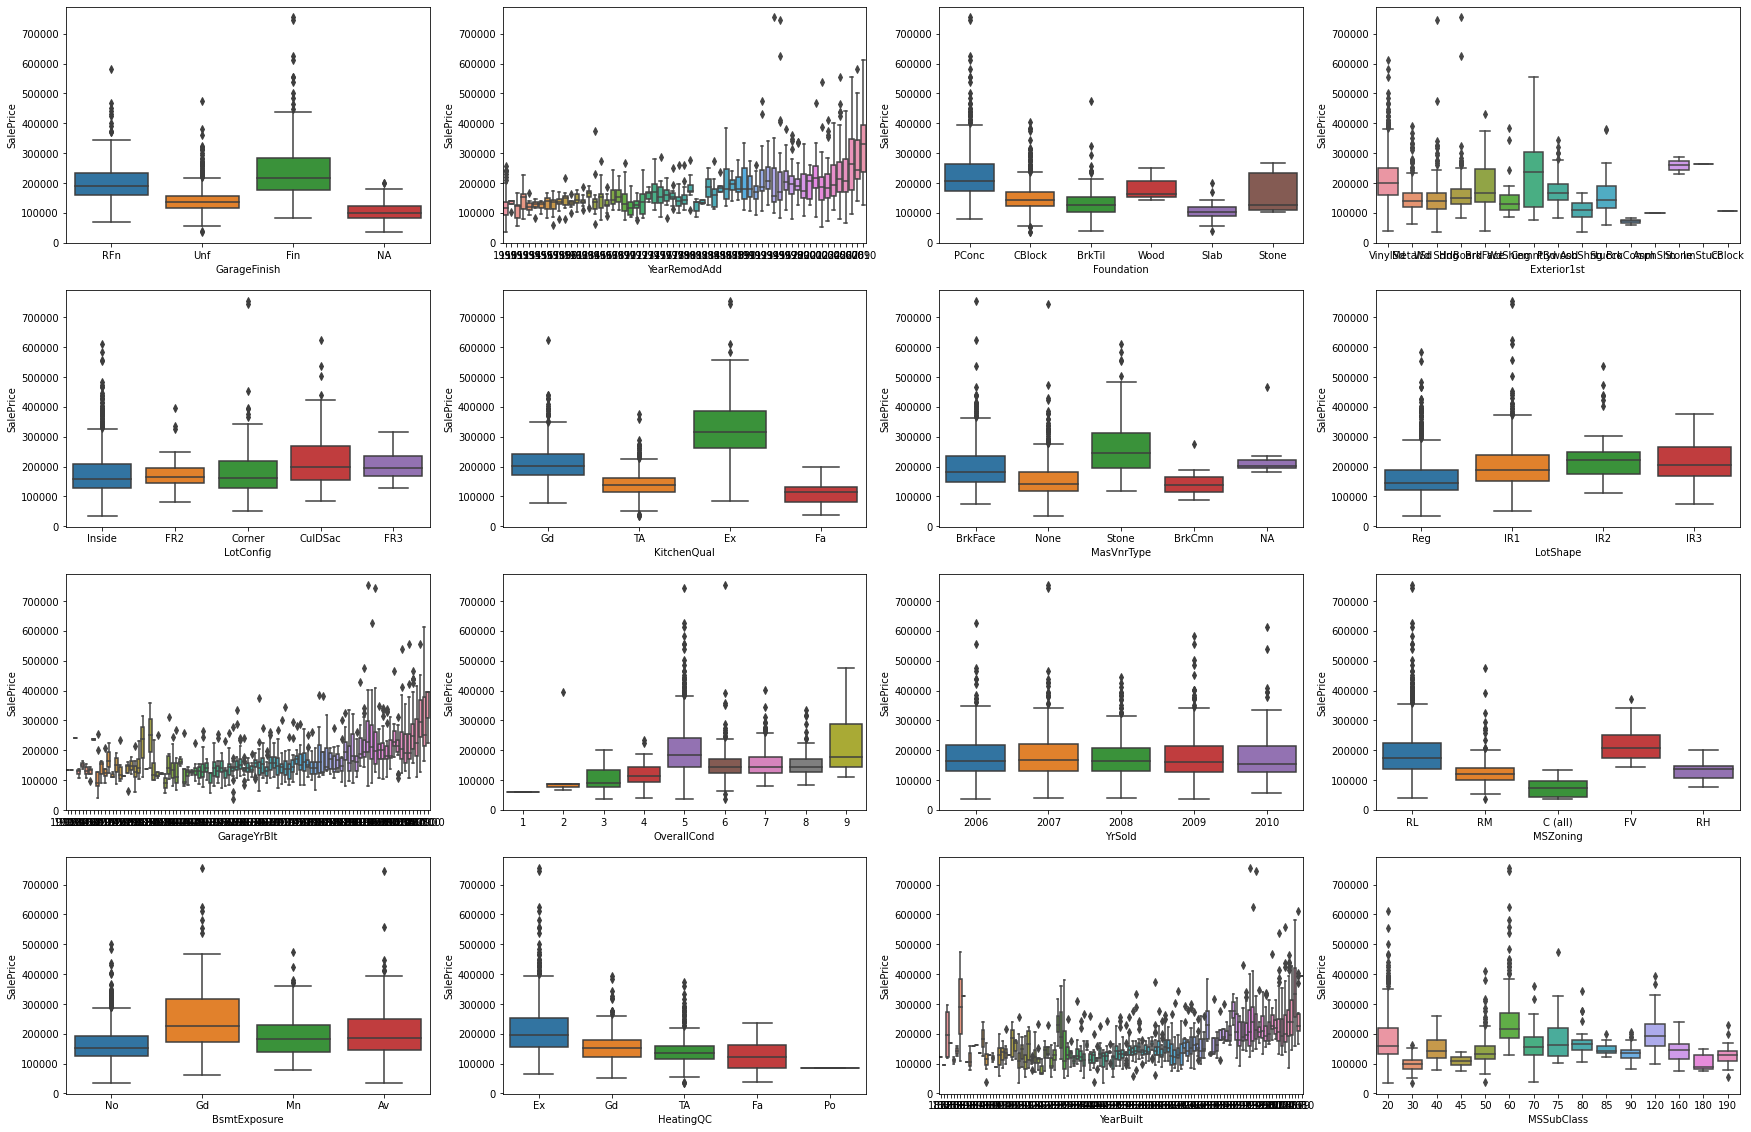

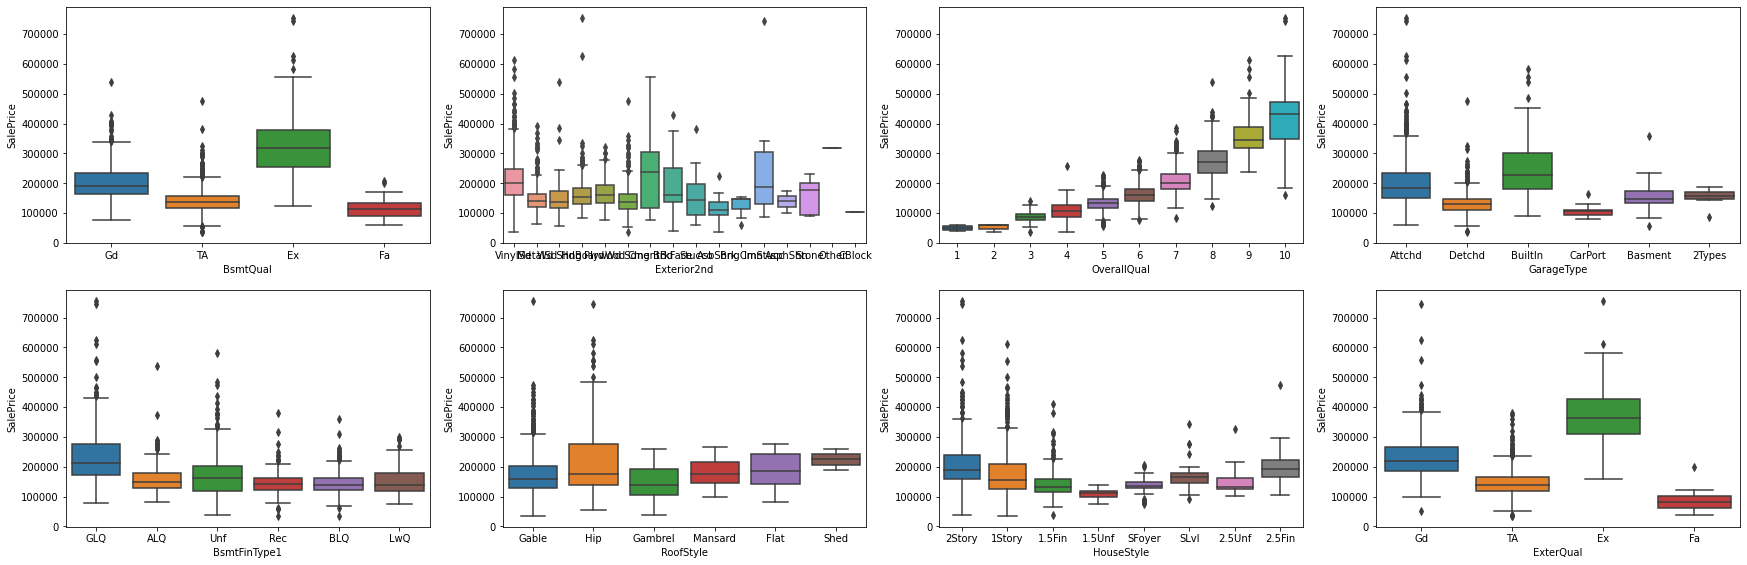

In [621]:
#check few categories to see any outliers
drawBoxPlot(data, catcolumns)

In [622]:
def drawHistogram(df, column):
  # An "interface" to matplotlib.axes.Axes.hist() method
  n, bins, patches = plt.hist(x=df[column], bins='auto', color='#0504aa',
                              alpha=0.7, rwidth=0.85)
  plt.grid(axis='y', alpha=0.75)
  plt.xlabel(column)
  plt.ylabel('Count')
  maxfreq = n.max()
  # Set a clean upper y-axis limit.
  plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
  plt.show()

In [623]:
def printUniqueValues(df, columns):
  for col in columns:
    print(df[col].unique)

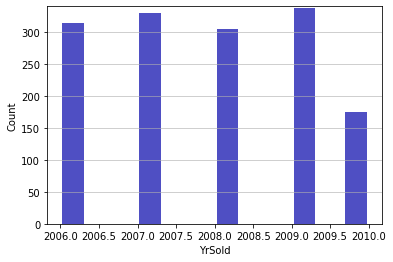

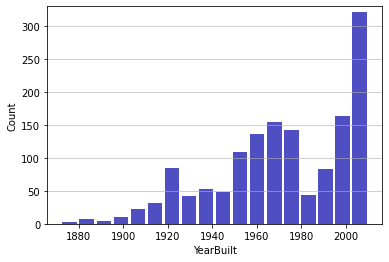

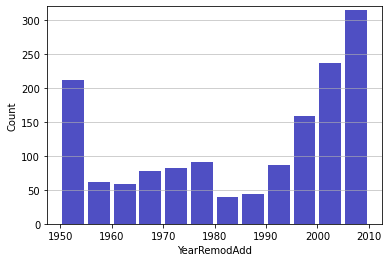

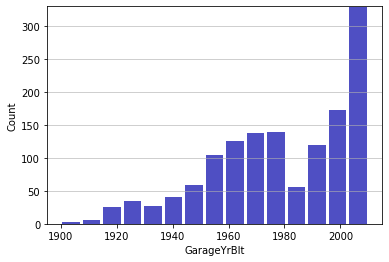

In [624]:
yearcolumns = ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']
for col in yearcolumns:
  drawHistogram(data, col)

In [625]:
#binning

def binYearData(df, columns):
  yrSoldbins = [1860,2006,2008,2010,2020]

  otherYearBins = [1860,1960,1980,2000,2010,2020]

  for col in columns:
    bins = otherYearBins
    if col == 'YrSold':  
      bins = yrSoldbins
    data[col] = pd.cut(data[col], bins)
  




In [626]:
#bin year data as there are too many years
binYearData(data, yearcolumns)

In [627]:
def populateNAwithNA(df,columns):
    for column in columns:
        df[column] = df[column].fillna('NA')
    return df

In [628]:
def outlier_treatment(df,column=None):
  """This function accepts a dataframe and a numerical column name for which outliers are treated"""
  df = df[df[column].between(df[column].quantile(0.05),df[column].quantile(0.95))]
  return df

def outlier_treatment_columns(df,columns):
    for column in columns:
        df = outlier_treatment(df, column)
    return df

In [629]:
#remove outliers
data = outlier_treatment_columns(data, numeric_columns)


### Create dummy variables

In [630]:
def replaceCategoricalColumnsWithDummies(df, columns):
    for col in columns:
        dummyVariables = pd.get_dummies(df[col], prefix = col)
        df = pd.concat([df, dummyVariables], axis = 1)
        df.drop([col], axis = 1, inplace = True)
    return df

In [631]:
data = replaceCategoricalColumnsWithDummies(data, catcolumns)

### Remove correlated predictors


In [632]:
#https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
def deleteHighlyCorrelatedColumns(df, minPercentage):
  corr_matrix = df.corr().abs()
  sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                    .stack()
                    .sort_values(ascending=False))
  
  correlatedCols = []
  for index, value in sol.items():
      if(value > 0.75) :
          correlatedCols.append(index[0])

  df = df.drop(columns = correlatedCols, axis = 1)

  return df

In [633]:
data = deleteHighlyCorrelatedColumns(data, 0.70)

In [634]:
numeric_columns = set(data.columns) - set(catcolumns)
numeric_columns_list = list(numeric_columns)

### Split to Train and Test Data

In [635]:
from sklearn.model_selection import train_test_split

np.random.seed(0)
df_train, df_test = train_test_split(data, train_size = 0.8, test_size=0.2, random_state=100)

### Rescaling the feature

In [636]:
df_train[numeric_columns].isnull().sum()

HalfBath                    0
GarageYrBlt_(2010, 2020]    0
MSZoning_RM                 0
GarageType_BuiltIn          0
MasVnrType_NA               0
                           ..
Fireplaces                  0
YearBuilt_(2010, 2020]      0
Foundation_PConc            0
Exterior2nd_AsbShng         0
BsmtFinType1_GLQ            0
Length: 121, dtype: int64

In [637]:
scaler = MinMaxScaler()
df_train[numeric_columns_list] = scaler.fit_transform(df_train[numeric_columns_list])



### Linear Regression


In [638]:
y_train = df_train.pop('SalePrice')
X_train = df_train

#### RFE

In [639]:
def calculate_rfe(xtrain, ytrain, num_features):
    lm = LinearRegression()
    lm.fit(xtrain, ytrain)
    
    rfe = RFE(estimator=lm, n_features_to_select=num_features)
    rfe = rfe.fit(xtrain, ytrain)
    
    #list(zip(xtrain.columns,rfe.support_,rfe.ranking_))
    
    return rfe, lm

In [640]:
rfe,_ = calculate_rfe(X_train, y_train, 100)

In [641]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('LotFrontage', True, 1),
 ('LotArea', False, 17),
 ('BsmtUnfSF', True, 1),
 ('1stFlrSF', True, 1),
 ('LowQualFinSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', True, 1),
 ('BsmtHalfBath', False, 4),
 ('FullBath', True, 1),
 ('HalfBath', True, 1),
 ('BedroomAbvGr', False, 12),
 ('KitchenAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 14),
 ('Fireplaces', True, 1),
 ('GarageArea', True, 1),
 ('WoodDeckSF', True, 1),
 ('OpenPorchSF', True, 1),
 ('EnclosedPorch', True, 1),
 ('3SsnPorch', True, 1),
 ('ScreenPorch', False, 18),
 ('PoolArea', True, 1),
 ('MiscVal', True, 1),
 ('MoSold', True, 1),
 ('GarageFinish_Fin', True, 1),
 ('GarageFinish_RFn', True, 1),
 ('GarageFinish_Unf', True, 1),
 ('YearRemodAdd_(1860, 1960]', False, 5),
 ('YearRemodAdd_(2010, 2020]', True, 1),
 ('Foundation_BrkTil', False, 9),
 ('Foundation_PConc', False, 11),
 ('Exterior1st_BrkFace', True, 1),
 ('Exterior1st_Plywood', True, 1),
 ('Exterior1st_WdShing', False, 3),
 ('LotConfig_Corner', True, 1),
 ('LotConfi

In [642]:
cols_include = X_train.columns[rfe.support_]
cols_include

Index(['LotFrontage', 'BsmtUnfSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'Fireplaces',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'GarageFinish_Fin', 'GarageFinish_RFn',
       'GarageFinish_Unf', 'YearRemodAdd_(2010, 2020]', 'Exterior1st_BrkFace',
       'Exterior1st_Plywood', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'KitchenQual_Ex',
       'KitchenQual_Fa', 'KitchenQual_TA', 'MasVnrType_NA', 'MasVnrType_None',
       'LotShape_IR2', 'GarageYrBlt_(2010, 2020]', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9', 'YrSold_(1860, 2006]',
       'YrSold_(2006, 2008]', 'YrSold_(2008, 2010]', 'YrSold_(2010, 2020]',
       'MSZoning_FV', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn',
       'BsmtExpos

In [643]:
cols_exclude = X_train.columns[~rfe.support_]
cols_exclude

Index(['LotArea', 'BsmtHalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'ScreenPorch', 'YearRemodAdd_(1860, 1960]', 'Foundation_BrkTil',
       'Foundation_PConc', 'Exterior1st_WdShing', 'MasVnrType_BrkCmn',
       'MasVnrType_Stone', 'LotShape_Reg', 'MSZoning_RM', 'MSSubClass_40',
       'MSSubClass_70', 'BsmtQual_Fa', 'BsmtQual_TA', 'OverallQual_3',
       'GarageType_Detchd', 'ExterQual_Ex'],
      dtype='object')

In [644]:
X_train_rfe = X_train[cols_include]

In [645]:
def getLinearRegressionModel(xtrain):
    # add constant
    xtrainlm = sm.add_constant(xtrain)
    
    # build linear model
    lrmodel = sm.OLS(y_train, xtrainlm).fit() 
    lrmodel.summary()
    
    return xtrainlm, lrmodel

In [646]:
# build linear model
X_train_lm, lm = getLinearRegressionModel(X_train_rfe)

In [647]:
X_train_rfe.columns

Index(['LotFrontage', 'BsmtUnfSF', '1stFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'Fireplaces',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'PoolArea', 'MiscVal', 'MoSold', 'GarageFinish_Fin', 'GarageFinish_RFn',
       'GarageFinish_Unf', 'YearRemodAdd_(2010, 2020]', 'Exterior1st_BrkFace',
       'Exterior1st_Plywood', 'LotConfig_Corner', 'LotConfig_CulDSac',
       'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'KitchenQual_Ex',
       'KitchenQual_Fa', 'KitchenQual_TA', 'MasVnrType_NA', 'MasVnrType_None',
       'LotShape_IR2', 'GarageYrBlt_(2010, 2020]', 'OverallCond_3',
       'OverallCond_4', 'OverallCond_5', 'OverallCond_6', 'OverallCond_7',
       'OverallCond_8', 'OverallCond_9', 'YrSold_(1860, 2006]',
       'YrSold_(2006, 2008]', 'YrSold_(2008, 2010]', 'YrSold_(2010, 2020]',
       'MSZoning_FV', 'BsmtExposure_Av', 'BsmtExposure_Gd', 'BsmtExposure_Mn',
       'BsmtExpos

In [648]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     30.18
Date:                Wed, 09 Feb 2022   Prob (F-statistic):           6.33e-75
Time:                        15:55:50   Log-Likelihood:                 382.50
No. Observations:                 267   AIC:                            -605.0
Df Residuals:                     187   BIC:                            -318.0
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0125      0.027     -0.466      0.642      -0.066       0.041
LotFrontage                   0.0973      0.032      3.003      0.003       0.033       0.161
BsmtUnfSF                    -0.0617      0.037     -1.652      0.100      -0.135       0.012
1stFlrSF                     -0.1023      0.089     -1.147      0.253      -0.278       0.074
LowQualFinSF              -1.168e-16   1.09e-16     -1.072      0.285   -3.32e-16    9.82e-17
GrLivArea                     0.5264      0.097      5.451      0.000       0.336       0.717
BsmtFullBath                  0.0168      0.013      1.298      0.196      -0.009       0.042
FullBath                      0.0328      0.021      1.548      0.123      -0.009       0.075
HalfBath                      0.0191      0.016      1.194      0.234      -0.012       0.051
KitchenAbvGr               9.687e-17   8.85e-17      1.094      0.275   -7.78e-17    2.72e-16
Fireplaces                    0.0258      0.013      2.017      0.045       0.001       0.051
GarageArea                    0.0929      0.029      3.211      0.002       0.036       0.150
WoodDeckSF                    0.0257      0.019      1.326      0.187      -0.013       0.064
OpenPorchSF                   0.0267      0.022      1.201      0.231      -0.017       0.071
EnclosedPorch                 0.0326      0.028      1.146      0.253      -0.023       0.089
3SsnPorch                 -3.393e-16   1.45e-16     -2.346      0.020   -6.25e-16    -5.4e-17
PoolArea                   1.632e-17   9.95e-17      0.164      0.870    -1.8e-16    2.13e-16
MiscVal                    4.108e-16   1.16e-16      3.555      0.000    1.83e-16    6.39e-16
MoSold                       -0.0190      0.021     -0.907      0.366      -0.060       0.022
GarageFinish_Fin             -0.0096      0.014     -0.708      0.480      -0.036       0.017
GarageFinish_RFn              0.0102      0.012      0.821      0.413      -0.014       0.035
GarageFinish_Unf             -0.0131      0.013     -1.031      0.304      -0.038       0.012
YearRemodAdd_(2010, 2020] -1.185e-16   1.18e-16     -1.008      0.315   -3.51e-16    1.14e-16
Exterior1st_BrkFace           0.0596      0.045      1.316      0.190      -0.030       0.149
Exterior1st_Plywood          -0.0307      0.037     -0.831      0.407      -0.104       0.042
LotConfig_Corner              0.0160      0.019      0.845      0.399      -0.021       0.053
LotConfig_CulDSac             0.0356      0.022      1.632      0.104      -0.007       0.079
LotConfig_FR2                 0.0177      0.028      0.637      0.525      -0.037       0.073
LotConfig_FR3                -0.0843      0.046     -1.835      0.068      -0.175       0.006
LotConfig_Inside              0.0025      0.014      0.172      0.863      

In [662]:
# get columns with higher p-value (> 0.1)
def getInsignificantColumns(lr, xtrain, min):    
    numAttributes = len(lr.pvalues)
    drop_columns_index = []
    drop_columns = []

    print(numAttributes)

    

    # pvalues contans const that is not in original column list
    # make a list of all columns which have p-value greater than
    for attributeIndex in range (1, numAttributes):
        if lr.pvalues[attributeIndex] > min:
            drop_columns_index.append(attributeIndex-1)
            drop_columns.append(xtrain.columns[attributeIndex-1])

   
    #print('Drop below columns with p-value greater than min')
    #print(drop_columns)
    #print(lr.pvalues[drop_columns])
    return drop_columns

In [670]:
def dropInsignificantColumns(lm, xtrain,min):
  drop_columns = getInsignificantColumns(lm, xtrain, min)
  xtrain.drop(drop_columns, axis=1, inplace=True)
  xtrainlm,lm = getLinearRegressionModel(xtrain)
  print(lm.summary())
  return xtrainlm,xtrain,lm

In [671]:
X_train_lm,X_train_rfe, lm = dropInsignificantColumns(lm,X_train_rfe,0.2)


42
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     70.64
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.13e-104
Time:                        16:07:25   Log-Likelihood:                 364.94
No. Observations:                 267   AIC:                            -655.9
Df Residuals:                     230   BIC:                            -523.2
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    

In [672]:
# iteration 2 of removing the high p-values
X_train_lm, X_train_rfe, lm = dropInsignificantColumns(lm,X_train_rfe,0.2)

41
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     70.64
Date:                Wed, 09 Feb 2022   Prob (F-statistic):          1.13e-104
Time:                        16:07:34   Log-Likelihood:                 364.94
No. Observations:                 267   AIC:                            -655.9
Df Residuals:                     230   BIC:                            -523.2
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    

In [668]:
X_train = X_train_rfe

### Residual Analysis of the train data

In [673]:
y_train_cnt = lm.predict(X_train_lm)

Text(0.5, 0, 'Errors')

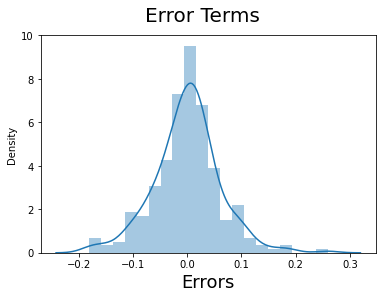

In [674]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

### Predictions

In [667]:
df_test[numeric_columns_list] = scaler.transform(df_test[numeric_columns_list])

In [675]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [676]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)


In [677]:
# Making predictions
y_pred = lm.predict(X_test_new)

### Model Evaluation

Text(0, 0.5, 'y_pred')

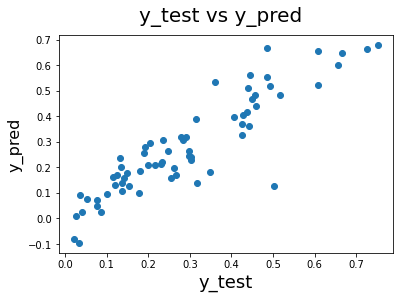

In [678]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label

In [680]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

In [681]:
df_results = calculate_residuals(lm, X_test_new, y_test)


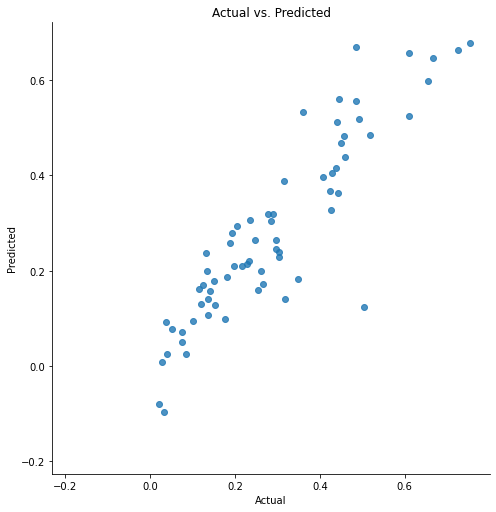

In [684]:
# Plotting the actual vs predicted values
sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
    
# Plotting the diagonal line
line_coords = np.arange(df_results.min().min(), df_results.max().max())
plt.plot(line_coords, line_coords,  # X and y points
          color='darkorange', linestyle='--')
plt.title('Actual vs. Predicted')
plt.show()

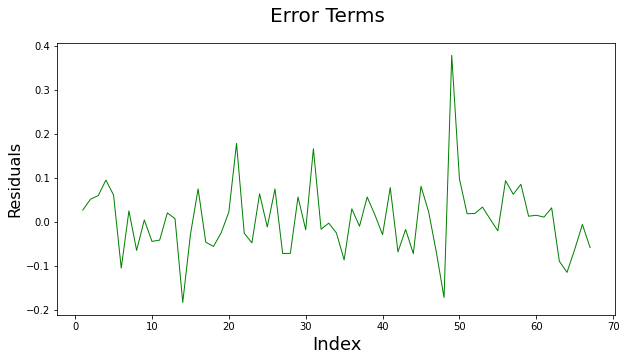

In [687]:
# Plotting y_test and y_pred to understand the spread.
index = [i for i in range(1,df_results.shape[0]+1,1)]
fig = plt.figure(figsize=(10, 5))
plt.plot(index,df_results.Residuals, color="green", linewidth=1, linestyle="-")
fig.suptitle('Error Terms', fontsize=20)          
plt.xlabel('Index', fontsize=18)                    
plt.ylabel('Residuals', fontsize=16)  
plt.show()

In [688]:
#r2 score for train data

from sklearn.metrics import r2_score
r2_score(y_train, y_train_cnt)

0.91706267758285

In [689]:
#r2 score for test data
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.790175806896717

## Regularization

In [703]:
allcols = X_train.columns
df_test_reg = df_test.copy();
X_train_reg = X_train
y_train_reg = y_train

y_test_reg = y_test
X_test_reg = X_test[allcols]

In [744]:
def getRegularizationModel(X_train, X_test, y_train, y_test, model, customAlpha = 0):
    print('Model: %s' %model)  

    if model == 'lasso':
        estimator_model = Lasso()
    else:
        estimator_model = Ridge()

    # kfold for randomization
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # grid search
    grid = dict()
    grid['alpha'] = [0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 20, 50, 100, 300, 500, 1000 ]
    if not customAlpha == 0:
      grid['alpha'] = [customAlpha]

    search = GridSearchCV(estimator_model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
    results = search.fit(X_train, y_train)

    alpha = results.best_params_["alpha"]
    
    print('Best fit alpha: %s' % results.best_params_)


    reg_model = results.best_estimator_
    reg_model.fit(X_train, y_train)
    y_train_pred = reg_model.predict(X_train)
    y_test_pred = reg_model.predict(X_test)

    r2train = r2_score(y_train,y_train_pred)
    r2test = r2_score(y_test,y_test_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print('r2 train %s; r2 test: %s; rmse test: %s; rmse test: %s' %(r2train,r2test,rmse_train,rmse_test))

 
   
    return reg_model

In [745]:
ridgeModel = getRegularizationModel(X_train_reg, X_test_reg, y_train_reg, y_test_reg, 'ridge')


Model: ridge
Best fit alpha: {'alpha': 0.2}
r2 train 0.9165417570287089; r2 test: 0.8048068694303204; rmse test: 0.061875331990942216; rmse test: 0.08061229193954787


In [720]:
lassoModel = getRegularizationModel(X_train_reg, X_test_reg, y_train_reg, y_test_reg, 'lasso')



Model: lasso
Best fit alpha: {'alpha': 0.005}
r2 train 0.8249160969550917; r2 test: 0.7422451229252784; rmse test: 0.08962022568375838; rmse test: 0.0926344335160095


### Model Evaluation

In [731]:
def plotPredictions_Reg(model):
    ypred = model.predict(X_test_reg) 
    fig = plt.figure()
    plt.scatter(y_test_reg, ypred)
     
    plt.xlabel('y', fontsize=14)
    plt.ylabel('predcited', fontsize=14)  
    plt.show()

def plotErrors_Reg(model):  
    ypred = model.predict(X_test_reg)
    fig = plt.figure()
    res=y_test_reg - ypred
    
    sns.distplot(res,kde=True)
    plt.title('Error distribution')
    plt.xlabel('Residuals')
    plt.show()

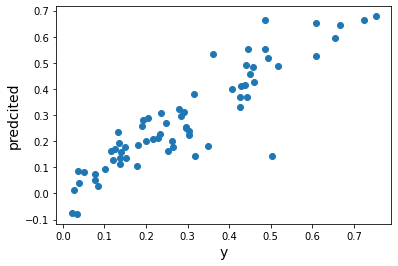

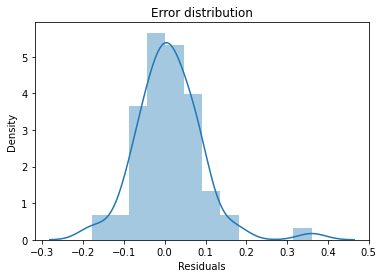

In [732]:
# ridge model
plotPredictions_Reg(ridgeModel)
plotErrors_Reg(ridgeModel)


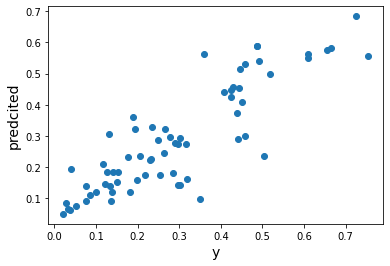

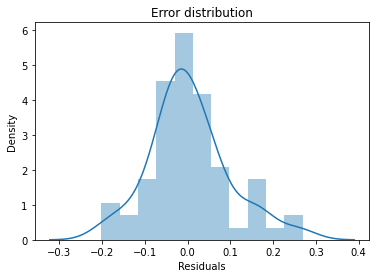

In [733]:
# lasso model
plotPredictions_Reg(lassoModel)
plotErrors_Reg(lassoModel)

In [738]:
#Most contributing factors according to ridge model
pd.Series(ridgeModel.coef_, index = allcols).sort_values(ascending=False)

GrLivArea                 0.448341
KitchenQual_Ex            0.198612
MSSubClass_120            0.116207
LotFrontage               0.097281
BsmtQual_Ex               0.094840
YearBuilt_(2000, 2010]    0.088097
OverallQual_8             0.087622
MSZoning_FV               0.084974
KitchenQual_Fa            0.083476
BsmtExposure_Gd           0.073507
OverallQual_7             0.073506
GarageArea                0.070992
HouseStyle_1Story         0.058847
BsmtFinType1_GLQ          0.056735
OverallCond_9             0.055101
Exterior1st_BrkFace       0.052514
LotConfig_CulDSac         0.035303
YearBuilt_(1980, 2000]    0.032642
FullBath                  0.032118
OverallCond_7             0.027775
WoodDeckSF                0.026000
BsmtFullBath              0.018435
Fireplaces                0.016431
KitchenQual_TA            0.015277
Exterior2nd_ImStucc       0.000000
MiscVal                   0.000000
MasVnrType_None          -0.020837
HeatingQC_TA             -0.021438
OverallCond_5       

In [739]:
pd.Series(lassoModel.coef_, index = allcols).sort_values(ascending=False)

GrLivArea                 0.290808
FullBath                  0.090627
BsmtFinType1_GLQ          0.066364
YearBuilt_(2000, 2010]    0.054901
OverallQual_7             0.046864
BsmtFullBath              0.028871
OverallQual_8             0.026783
LotFrontage               0.000000
MSSubClass_160           -0.000000
HeatingQC_TA             -0.000000
YearBuilt_(1960, 1980]   -0.000000
YearBuilt_(1980, 2000]    0.000000
MSSubClass_120            0.000000
Exterior2nd_Stucco       -0.000000
BsmtQual_Ex               0.000000
Exterior2nd_ImStucc       0.000000
MSZoning_FV               0.000000
GarageType_Basment       -0.000000
BsmtFinType1_LwQ         -0.000000
BsmtExposure_Gd           0.000000
OverallCond_9             0.000000
BsmtUnfSF                -0.000000
OverallCond_7             0.000000
Fireplaces                0.000000
GarageArea                0.000000
WoodDeckSF                0.000000
MiscVal                   0.000000
Exterior1st_BrkFace       0.000000
LotConfig_CulDSac   

In [746]:
ridgeModel_double = getRegularizationModel(X_train_reg, X_test_reg, y_train_reg, y_test_reg, 'ridge',customAlpha=0.4)

Model: ridge
Best fit alpha: {'alpha': 0.4}
r2 train 0.9153709111501125; r2 test: 0.814512170915821; rmse test: 0.0623078486101151; rmse test: 0.0785826578287351


In [747]:
pd.Series(ridgeModel_double.coef_, index = allcols).sort_values(ascending=False)

GrLivArea                 0.428147
KitchenQual_Ex            0.180708
MSSubClass_120            0.109318
LotFrontage               0.095803
BsmtQual_Ex               0.092913
OverallQual_8             0.090573
YearBuilt_(2000, 2010]    0.086436
MSZoning_FV               0.082034
OverallQual_7             0.073932
KitchenQual_Fa            0.071570
GarageArea                0.070574
BsmtExposure_Gd           0.068418
BsmtFinType1_GLQ          0.056556
HouseStyle_1Story         0.053411
OverallCond_9             0.049211
Exterior1st_BrkFace       0.047907
FullBath                  0.034505
LotConfig_CulDSac         0.033734
YearBuilt_(1980, 2000]    0.032841
OverallCond_7             0.027690
WoodDeckSF                0.023338
BsmtFullBath              0.019988
Fireplaces                0.017808
KitchenQual_TA            0.011092
Exterior2nd_ImStucc       0.000000
MiscVal                   0.000000
HeatingQC_TA             -0.020755
MasVnrType_None          -0.022402
OverallCond_5       

In [748]:
#lasso double
lassoModel_double = getRegularizationModel(X_train_reg, X_test_reg, y_train_reg, y_test_reg, 'lasso',customAlpha=0.01)

Model: lasso
Best fit alpha: {'alpha': 0.01}
r2 train 0.7668334789370916; r2 test: 0.7199451238911498; rmse test: 0.10342273535097145; rmse test: 0.09655851402841938


In [749]:
pd.Series(lassoModel_double.coef_, index = allcols).sort_values(ascending=False)

GrLivArea                 0.176303
FullBath                  0.125814
BsmtFinType1_GLQ          0.060014
YearBuilt_(2000, 2010]    0.038956
OverallQual_7             0.035447
BsmtFullBath              0.013032
LotFrontage               0.000000
BsmtQual_Ex               0.000000
YearBuilt_(1960, 1980]   -0.000000
YearBuilt_(1980, 2000]    0.000000
MSSubClass_120            0.000000
MSSubClass_160            0.000000
OverallQual_4            -0.000000
Exterior2nd_ImStucc       0.000000
Exterior2nd_Stucco       -0.000000
BsmtExposure_Gd           0.000000
OverallQual_8             0.000000
GarageType_Basment       -0.000000
BsmtFinType1_LwQ         -0.000000
HeatingQC_TA             -0.000000
OverallCond_9             0.000000
MSZoning_FV               0.000000
BsmtUnfSF                -0.000000
Fireplaces                0.000000
GarageArea                0.000000
WoodDeckSF                0.000000
MiscVal                   0.000000
Exterior1st_BrkFace      -0.000000
LotConfig_CulDSac   